# **<다음 분기에 어떤 게임을 설계해야 할까?>**

---


1. 분석 목적 : 위의 고민을 해결하기 위해, 기존의 데이터에 기반하여 인사이트를 얻고, 의사결정을 하기 위함.

2. 분석 방법 : 아래 배운 내용을 참조 

*   Sprint 1 : EDA, Feature Engineering, Data Manipulation, Data Visualization
*   Sprint 2 : Hypothesis Test, CI, Bayesian
*   Sprint 3 : DR, PCA, Cluster


3. 필수 사항 : 아래 질문에 대답해야 함.


*   연도별 게임의 트렌드가 있을까요?
*   출고량이 높은 게임에 대한 분석 및 시각화 프로세스
*   지역에 따라 선호하는 게임 장르가 다른가요?

4. Data Description

  Name : 게임의 이름입니다.

  Platform : 게임이 지원되는 플랫폼의 이름입니다.

  Year : 게임이 출시된 연도입니다.

  Genre : 게임의 장르입니다.

  Publisher : 게임을 제작한 회사입니다.

  NA_Sales : 북미지역에서의 출고량입니다.

  EU_Sales : 유럽지역에서의 출고량입니다.

  JP_Sales : 일본지역에서의 출고량입니다.

  Other_Sales : 기타지역에서의 출고량입니다.

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "notebook_connected" # ipynb 파일을 업로드시 주피터에선 보이지만, 외부환경에서 보이지 않는 이슈를 해결해줌
import warnings
warnings.filterwarnings(action='ignore')

url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'
df = pd.read_csv(url)
df = df[df.columns[1:]]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


# **EDA & Data Preprocessing**

시작 : 결측치와 데이터타입 & 위에서 5번째 줄까지 어떻게 생겼는지 확인

step1 : 숫자형 데이터와 카테고리형 데이터를 분류하고


step2 : 숫자형 데이터의 단위를 통일


step3 : 결측치를 feature 성격에 따라 채우고, 채울 수 없는 feature는 drop


step4 : 게임명, 지원플랫폼, 출시연도, 장르, 게임제작사가 동일한 데이터가 2행 이상 존재 시 중복처리 or 합산




In [2]:
print(df.info()) # 연도, 장르, 퍼블리셔가 빈값이 있음
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB
None


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


**step1. 숫자형 데이터와 카테고리형 데이터를 분류**

In [33]:
NUM_COL = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
CAT_COL = ['Name', 'Platform', 'Year', 'Genre', 'Publisher']



**step2 : 숫자형 데이터의 단위를 통일**


In [34]:
def unit_converter(col):
  """
  col의 value를 확인해 계산하기 쉬운 수치로 만들어 수정한 데이터프레임을 반환함
  기본 단위는 백 만(M)으로, value는 [1.K로 끝남 2.M으로 끝남 3.해당없음] 3종류로 나뉨.
  각각 불필요한 str 제거 -> 숫자형 변환 -> 단위에 맞는 숫자를 곱해주는 과정을 거침

  @param {columns} 데이터 프레임 내 특정 feature
  @return {DataFrame} converter과정을 거친 데이터프레임을 반환
  """  
  df.loc[df[col].str.contains('K'), 'contains_K'] = True
  df['contains_K'] = df['contains_K'].fillna(False)
  df[col] = df[col].replace('K|M', '', regex=True).astype(float)
  df.loc[df['contains_K']==True, col] = df[col]*1000
  df[col] = df[col]*1000000
  del df['contains_K']

  return df

# 숫자형 자료가 들어가야 하는 feature 전체에, 위에서 만든 단위변환하는 함수를 적용함
for i in range(0, len(NUM_COL)):
  df = unit_converter(NUM_COL[i])

In [45]:
df['Total'] = df[NUM_COL].sum(axis=1)
df['Mean'] = df[NUM_COL].mean(axis=1)
df.sort_values('Total', ascending=False)
# df.loc[df.Name.str.contains('Wii Sports')]

df[df['Mean']>=10000000].sort_values('Total', ascending=False)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total,Mean
1971,Pokemon X/Pokemon Y,3DS,2013.0,NaN,Nintendo,5.170000e+12,4050000.0,4.340000e+06,790000.0,5.170009e+12,1.292502e+12
1964,The Legend of Zelda: Ocarina of Time,N64,1998.0,Action,Nintendo,4.100000e+12,1890000.0,1.450000e+06,160000.0,4.100004e+12,1.025001e+12
9829,Super Mario Bros. 3,GBA,2003.0,Platform,Nintendo,2.930000e+12,1250000.0,8.300000e+05,200000.0,2.930002e+12,7.325006e+11
3589,Final Fantasy IX,PS,2000.0,Role-Playing,SquareSoft,1.620000e+06,770000.0,2.780000e+12,140000.0,2.780003e+12,6.950006e+11
13935,Crash Team Racing,PS,1999.0,Racing,Sony Computer Entertainment,2.570000e+12,1570000.0,4.400000e+05,210000.0,2.570002e+12,6.425006e+11
...,...,...,...,...,...,...,...,...,...,...,...
9193,FairlyLife: MiracleDays,PSP,2010.0,Adventure,Piacci,0.000000e+00,0.0,1.000000e+10,0.0,1.000000e+10,2.500000e+09
7639,Rakushou! Pachi-Slot Sengen 4,PS2,2006.0,Misc,Tecmo Koei,0.000000e+00,0.0,1.000000e+10,0.0,1.000000e+10,2.500000e+09
12332,The Cages: Pro Style Batting Practice,Wii,2010.0,Sports,Konami Digital Entertainment,1.000000e+10,0.0,0.000000e+00,0.0,1.000000e+10,2.500000e+09
2908,Wii Sports,Wii,2006.0,Sports,Nintendo,4.149000e+07,29020000.0,3.770000e+06,8460000.0,8.274000e+07,2.068500e+07


**step3 : 결측치를 feature별 성격에 따라 채우고, 채울 수 없는 feature는 drop**

In [5]:
"""
=================================
1차 탐색
=================================
전제1 : 같은 게임이라면 장르가 같다. 
전제2 : 같은 게임이라면 제작사가 같다.
각 카테고리간 교차분석을 실행하고, 관측된 값이 0이면 False, 1이상이면 True로 replace해준다. 
가로로 더한 결과가 1이라는 건, 특정 게임은 중복 없이 unique한 장르만 가진다, 특정 게임은 unique한 제작사에서만 제작한다는 뜻.
value_counts해 1이 95% 이상 차지할 때 2차 탐색 실행
"""
hyp1_df = pd.crosstab(df['Name'], df['Genre'])
hyp1_df = hyp1_df.apply(lambda x: [False if y==0 else True for y in x])
hyp1_df['Sum'] = hyp1_df.sum(axis=1)
print(hyp1_df['Sum'].value_counts()) 
print('>>>>> 1이 99.9%로, 게임명이 같다면, 같은 장르라고 가정함', '\n')
# 같은 게임이면 같은 장르를 가질테니, 게임 이름별로 집단을 묶어서, 장르를 나열해서 존재하는 앞,뒤값으로 장르의 결측치를 채워줌.
# 이 때, 게임 x의 정보가 row 1개뿐이라면 장르는 그대로 빈 값을 유지함. 아래 코드 실행 시 Genre 결측치 50개 -> 30개로 감소
df['Genre'] = df.groupby('Name')['Genre'].apply(lambda x:x.fillna(method='ffill').fillna(method='bfill')) 


hyp2_df = pd.crosstab(df['Name'], df['Publisher'])
hyp2_df = hyp2_df.apply(lambda x: [False if y==0 else True for y in x])
hyp2_df['Sum'] = hyp2_df.sum(axis=1)
print(hyp2_df['Sum'].value_counts()) 
print('>>>>> 1이 96.7% {}로, 게임명이 같다면, 제작사도 거의 같다고 가정함', '\n')
# 기준은 만족하지만, 같은 게임이어도 제작사가 다른 경우가 예상보다 많이 존재함.
# 패턴을 살펴보니 제작년도,게임명이 같으면 제작사가 같으나(case A) 제작년도가 다르면 제작사가 다른 경우가 꽤 있음(case B)
# case A의 경우도, 제공 언어가 다르거나 라이센스 종료 등으로 제작사가 다른 경우도 있기에 전제2에 해당하지 않는 예시도 존재한다.
# 위 예외 사항은 일단 보류하고, 전제2로 결측치를 채운다.
# 이 때, 게임 x의 정보가 row 1개뿐이라면 제작사는 그대로 빈 값을 유지함. 아래 코드 실행 시 Publisher 결측치 58개 -> 51개
df['Publisher'] = df.groupby('Name')['Publisher'].apply(lambda x:x.fillna(method='ffill').fillna(method='bfill')) 



"""
=================================
2차 탐색
=================================
전제 : 게임 이름, 장르, 제작사가 같다면 제작년도도 같을 것

전제의 논리가 조금 부족하지만 게임업계 특성상, 출시되고 얼마안가 사라지는 게임이 수두룩하다.
이름,장르,제작사가 같고 게임을 실행할 하드웨어가 다르다면 같은 년도에 출시했다가 사라졌다는 판단을 했고,
이 생각을 검증할 방법을 잘 모르겠으나, 대략적인 패턴을 찾아봤을 때 내 가정이 틀리진 않은 것 같다.
"""

# 이렇게까지 지저분하게 하지 않아도 될 텐데 방법을 모르겠음.
# [게임명, 제작사, 장르] 가 같으면 제작년도가 같을 것이다를 확인하기 위해 작성했던 코드. 
# [게임명, 제작사, 장르]를 기준으로 데이터를 묶어, 게임명이 전체데이터에 몇 번이나 등장하는지, Year가 비어있는 칸은 몇 개인지를 세서 feature로 만들어준다.
# 다른 조건이 모두 같을때 제작년도도 정말 같을지 패턴을 쉽게 보기 위해 (게임명이 조회된 횟수) - (빈칸 수) >= 2 를 만족해야 가정이 맞다고 판단함.
# 조건이 모두 같은 데이터가 두 번 조회됬는데, Year의 빈칸이 1개일 때는 가정이 틀릴 확률이 높음.
# 한 번 조회됬는데 Year가 빈 칸일 때는 유추할 수 없음.
# 조건을 만족하는 집단만 따로 필터해, Year의 빈 칸을 채워줌. 아래코드 실행 시 Year의 결측치는 271 -> 236개
origin_df = df.groupby(['Name', 'Publisher','Genre']).agg({'Year': lambda x: x.isnull().sum()}).sort_values('Year')
df['Name_copy'] = df['Name']
sub_df = df[['Name','Publisher','Genre','Name_copy']]
sub_df = sub_df.groupby(['Name', 'Publisher','Genre']).count().sort_values('Name_copy',ascending=False)

temp_df = origin_df.join(sub_df)
temp_df.columns = ['count_null_in_year', 'count_name']
temp_df['diff'] = temp_df['count_name'] - temp_df['count_null_in_year']
temp_df.sort_values('diff', ascending=False, inplace=True)
temp_df = temp_df[(~(temp_df.count_null_in_year==0)) & (temp_df['diff']>=2)]

midx = temp_df.index
COND = df.set_index(['Name','Publisher','Genre']).index.isin(midx)
year_join_df = df[COND]
year_join_df['New_Year'] = year_join_df.groupby(['Name', 'Publisher','Genre'])['Year'].apply(lambda x:x.fillna(method='ffill').fillna(method='bfill'))
year_join_df = year_join_df[CAT_COL + ['New_Year']]

df = df.join(year_join_df.set_index(CAT_COL), on=CAT_COL, how='left')
df.loc[df.New_Year.notnull()&df.Year.isnull(), 'Year'] = df.New_Year
df.drop(columns=['New_Year', 'Name_copy'], inplace=True)

1    11459
2        4
Name: Sum, dtype: int64
>>>>> 1이 99.9%로, 게임명이 같다면, 같은 장르라고 가정함 

1    11063
2      347
3       26
4        6
Name: Sum, dtype: int64
>>>>> 1이 96.7% {}로, 게임명이 같다면, 제작사도 거의 같다고 가정함 



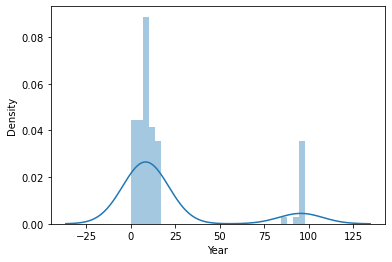

In [6]:
sns.distplot(df[df.Year<100]['Year']);
# 년도가 이상해보이는 값들이 있음. 
# 년도가 100이하인 것 중, 0~16까지는 2000을 더해 20xx년을, 86~98까지는 1900을 더해 19xx년을 만들어준다.
# 게임명 뒤에 :2007 이렇게 오면 보통 년도가 06, 07로 짤려있거나,
# 이상한 연도를 가진 게임명을 가지고 전체데이터 중 그 게임명이 포함된것만 필터해서 봤더니 앞에 두자리를 일부러 뺀 느낌이 강하게 들었다. 
# 이렇게 해도, 100년 미만의 row를 다 지운 것과 연도 분포에 큰 차이가 없다 ==> 내 생각이 틀리진 않았다.
df.loc[(df['Year']<=16), 'Year'] = df['Year']+int(2000)
df.loc[(df['Year']>=86) & (df['Year']<=98), 'Year'] = df['Year']+int(1900)

**step4 : 게임명, 지원플랫폼, 출시연도, 장르, 게임제작사가 동일한 데이터가 2행 이상 존재 시 중복처리 or 합산**

In [7]:
print(df.loc[df.duplicated(subset=CAT_COL)]) 
print('>>>>>>> 카테고리 데이터의 값이 모두 동일한 중복 행이 2개 발견됨.', '\n')

print(df.loc[(df.Name=='Madden NFL 13')&(df.Year==2012)&(df.Platform=='PS3')])
print('>>>>>>> [Madden NFL 13] 유럽국가 출고량 10,000을 누락해서 추가한 행으로 보임. 중복 제거하되, 출고량 합산해줄 것.', '\n')

print(df.loc[(df.Name=='Wii de Asobu: Metroid Prime')])
print('>>>>>>> [Wii de Asobu: Metroid Prime] 완전 동일한 행으로, 중복 제거하겠음', '\n')

df.drop_duplicates(subset=CAT_COL, keep='first', inplace=True)
df.loc[(df.Name=='Madden NFL 13')&(df.Year==2012)&(df.Platform=='PS3'), 'EU_Sales'] = 240000

                              Name Platform    Year     Genre  \
8717                 Madden NFL 13      PS3  2012.0    Sports   
9184   Wii de Asobu: Metroid Prime      Wii     NaN   Shooter   
15705           Sonic the Hedgehog      PS3  2006.0  Platform   

             Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  
8717   Electronic Arts       0.0   10000.0       0.0          0.0  
9184          Nintendo       0.0       0.0   20000.0          0.0  
15705             Sega  410000.0   70000.0   40000.0     660000.0  
>>>>>>> 카테고리 데이터의 값이 모두 동일한 중복 행이 2개 발견됨. 

               Name Platform    Year   Genre        Publisher   NA_Sales  \
7346  Madden NFL 13      PS3  2012.0  Sports  Electronic Arts  2110000.0   
8717  Madden NFL 13      PS3  2012.0  Sports  Electronic Arts        0.0   

      EU_Sales  JP_Sales  Other_Sales  
7346  230000.0       0.0     220000.0  
8717   10000.0       0.0          0.0  
>>>>>>> [Madden NFL 13] 유럽국가 출고량 10,000을 누락해서 추가한 행으로 보임. 중복 제거하되, 출고량 합산해

In [8]:
# 보간할 수 있는 값을 충분히 채웠다고 생각하므로, 나머지 null이 있는 row를 모두 삭제하고 진행하겠음
# null을 갖고 가면, 나중에 어떤 코드에서 np.nan은 안됩니다를 뱉을지 모르기에 미리 하는게 속 편하다.
df.dropna(inplace=True)
df = df.reset_index(drop=True)
df.shape

(16295, 9)

In [9]:
# 약 40년에 걸친 지역별 게임 출고량 데이터를 살펴볼 예정.
# 가장 많이 언급된 키워드를 살펴보면 Action 장르, 제작사는 Electronic Arts, 제작년도는 2009년, 플랫폼은 DS로 확인된다.
df['Year'] =df['Year'].astype(int).astype('category')
df[CAT_COL].describe()

,Name,Platform,Year,Genre,Publisher
count,16295,16295,16295,16295,16295
unique,11295,31,39,12,576
top,Need for Speed: Most Wanted,DS,2009,Action,Electronic Arts
freq,12,2130,1432,3258,1343


In [26]:
# 지역별 매출의 통계량을 살펴보자.
# 4분위 수를 구했을 때 Q3까지는 비교적 완만하게 오르다가, Q4(MAX)에서 수치가 급등하기 때문에 데이터별 편차가 크다는 걸 알 수 있다.
# 최대값 혼자서 각 지역별 매출의 13~36%를 차지하는 걸 보면, 소위말해 잘나가는 게임의 출고량은 어마무시하다는 뜻이다.
# 4 분위수 (Quartile) 란? :
# 데이터의 분포를 작은 수 부터 큰 수로 쭉 나열하여, 4등분을 했을때 4등분한 위치에 있는 값을 각각 Q1, Q2, Q3, Q4로 나눈 것 
df[NUM_COL].describe().astype(int)

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16295,16295,16295,16295
mean,1920484643,952586110,467705684,231407371
std,-2147483648,-2147483648,-2147483648,-2147483648
min,0,0,0,0
25%,0,0,0,0
50%,80000,20000,0,10000
75%,240000,110000,40000,40000
max,-2147483648,-2147483648,-2147483648,-2147483648


In [28]:
# 실제로 지역별 출고량의 분포를 보기 위해 violinplot을 그려봤다. 
# 데이터 분포가 큰 녀석들때문에, violinplot이 직선처럼 그려진다.
# 내 주장이 맞을지 확인하기 위해 통계적 가설검정을 실행할건데, 검정 시 평균, 분산등이 사용되므로 편차가 아주 큰 데이터는 잘못된 결과를 이끌어 낼 수 있다. 
# 그래서 데이터의 outlier를 제거해주는 방법을 쓰지만, 나는 머신러닝을 하는게 아니기 때문에 일단은 그대로 간다. 
df_tidy = df.melt(id_vars=CAT_COL,var_name="Country", value_name="Sales")

import plotly.express as px

fig = px.violin(df_tidy, y="Sales", x="Country", box=True)
fig.show('svg')

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    C:\Users\dbsgu\anaconda3
    C:\Users\dbsgu\anaconda3\Library\mingw-w64\bin
    C:\Users\dbsgu\anaconda3\Library\usr\bin
    C:\Users\dbsgu\anaconda3\Library\bin
    C:\Users\dbsgu\anaconda3\Scripts
    C:\Users\dbsgu\anaconda3\bin
    C:\Users\dbsgu\anaconda3\condabin
    C:\Program Files (x86)\Intel\iCLS Client
    C:\Program Files\Intel\iCLS Client
    C:\WINDOWS\system32
    C:\WINDOWS
    C:\WINDOWS\System32\Wbem
    C:\WINDOWS\System32\WindowsPowerShell\v1.0
    C:\Program Files\Intel\WiFi\bin
    C:\Program Files\Common Files\Intel\WirelessCommon
    C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\DAL
    C:\Program Files\Intel\Intel(R) Management Engine Components\DAL
    C:\Program Files (x86)\Intel\Intel(R) Management Engine Components\IPT
    C:\Program Files\Intel\Intel(R) Management Engine Components\IPT
    C:\WINDOWS\System32\OpenSSH
    C:\Users\dbsgu\AppData\Local\Microsoft\WindowsApps
    C:\Users\dbsgu\AppData\Local\atom\bin
    C:\Users\dbsgu\AppData\Local\Programs\Microsoft VS Code\bin
    C:\Program Files (x86)\ESTsoft\ALSee\x64

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


In [13]:
"""
=============================
데이터 표준화, 이상치 제거, 정규화 >> 시행하지 않음
=============================
 
[접근1]
step1 : RobustScaler 적용할 feature만 분리해, 표준화
step2 : z-score를 활용한 이상치 제거
step3 : MinMax로 정규화

[접근2]
MAD(med_abs_deviation)로 평균의 영향을 덜 받도록 outlier 제거
"""

# from sklearn.preprocessing import RobustScaler
# import scipy as sp
# import scipy.stats

# print('feature 들의 평균 값')
# print(df.mean())
# print('\nfeature 들의 분산 값')
# print(df.var())

# # # step1 : 출고량에 해당하는 values들에 RobustScaler 적용해 표준화함.
# robustScaler = RobustScaler()
# print(robustScaler.fit(df[NUM_COL]))
# train_data_robustScaled = robustScaler.transform(df[NUM_COL])
# df_scaled = pd.DataFrame(train_data_robustScaled, columns=NUM_COL)

# print('표준화 후 feature 들의 평균 값')
# print(df_scaled.mean())
# print('\n표준화후feature 들의 분산 값')
# print(df_scaled.var())

# # step2 : Z_Score
# # check Z score 
# df_scaled.
# # df_Zscore = pd.DataFrame()
# # outlier_dict = {}
# # outlier_idx_list = []

# # for one_col in df_scaled.columns:
# #     # print("Check",one_col)
# #     df_Zscore[f'{one_col}_Zscore'] = sp.stats.zscore(df_scaled[one_col])
# #     outlier_dict[one_col] = df_Zscore[f'{one_col}_Zscore'][(df_Zscore[f'{one_col}_Zscore']>2)|(df_Zscore[f'{one_col}_Zscore']<-2)]
# #     outlier_idx_list.append(list(outlier_dict[one_col].index))
# #     if len(outlier_dict[one_col]):
# #         print(one_col,'Has outliers\n', outlier_dict[one_col])
# #     else:
# #         print(one_col,"Has Not outlier")
# #     print()


# # print("Before", df_scaled.shape)
# # all_outlier_idx = sum(outlier_idx_list,[])
# # df_scaled = df_scaled.drop(all_outlier_idx)
# # print("After (drop outlier)", df_scaled.shape)

# # #  step3 : 0~1사이 값을 가지는 value들로 정규화 하기
# from sklearn.preprocessing import MinMaxScaler

# # # MinMaxScaler객체 생성
# scaler = MinMaxScaler()
# # MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
# scaler.fit(df_scaled)
# df_scaled = scaler.transform(df_scaled)

# # transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
# df_scaled = pd.DataFrame(data=df_scaled, columns=NUM_COL)
# print('feature들의 최소 값')
# print(df_scaled.min())
# print('\nfeature들의 최대 값')
# print(df_scaled.max())

# # scaled된 values로 바꿔주기
# df[NUM_COL] = df_scaled
# # 그래프용으로 쓸 tidy_data 만들기
# df_tidy = df.melt(id_vars=CAT_COL,var_name="Country", value_name="Sales")

'\n=============================\n데이터 표준화, 이상치 제거, 정규화 >> 시행하지 않음\n=============================\n \n[접근1]\nstep1 : RobustScaler 적용할 feature만 분리해, 표준화\nstep2 : z-score를 활용한 이상치 제거\nstep3 : MinMax로 정규화\n\n[접근2]\nMAD(med_abs_deviation)로 평균의 영향을 덜 받도록 outlier 제거\n'

In [14]:
# def mad_based_outlier(points, thresh=3.5):
#     """
#     Returns a boolean array with True if points are outliers and False 
#     otherwise.

#     Parameters:
#     -----------
#         points : An numobservations by numdimensions array of observations
#         thresh : The modified z-score to use as a threshold. Observations with
#             a modified z-score (based on the median absolute deviation) greater
#             than this value will be classified as outliers.

#     Returns:
#     --------
#         mask : A numobservations-length boolean array.

#     References:
#     ----------
#         Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
#         Handle Outliers", The ASQC Basic References in Quality Control:
#         Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
#     """
#     if len(points.shape) == 1:
#         points = points[:,None]
#     median = np.median(points, axis=0)
#     diff = np.sum((points - median)**2, axis=-1)
#     diff = np.sqrt(diff)
#     med_abs_deviation = np.median(diff)

#     modified_z_score = 0.6745 * diff / med_abs_deviation

#     return modified_z_score > thresh

# filter_array = mad_based_outlier(df_tidy['Sales'])
# df_tidy['filter'] = filter_array
# df_tidy = df_tidy[df_tidy['filter']==False]
# # df_tidy['filter'].value_counts()

# **Statistics**

목표를 다시 되새겨 보자. 

다음 분기에 어떤 게임을 개발해야 하는가? 라는 질문에 대답하기 위해 아래 항목을 차례대로 분석하고, 인사이트를 종합해 결론을 내리려고 한다.

1. 출고량이 많은 게임들의 패턴이 어떤지 >> 지역별 출고량을 합한 전체 출고량 상위 20%의 데이터의 패턴 확인
2. 시간흐름에 따라 트렌드가 있는지 >> 연도별 최빈치 heatmap & chi square test
3. 지역에 따라 선호하는 게임 장르가 다른지 >> 2 way ANOVA 



---




## 1. 출고량이 많은 게임들의 패턴이 어떤가? 

16,000여 개를 다 분석하는 것도 좋지만, 정보가 많이 없는 상황이기 때문에 파레토의 법칙을 적용하기로 했다. 

총 출고량의 크기를 큰 것부터 작은 순으로 내림차순했을 때, 상위 20%를 차지하는 그룹만 따로 분리했다. 총 3,295개의 sample이 있음

In [15]:
df['Total_Sales'] = df[NUM_COL].sum(axis=1)
upper_group = df[df['Total_Sales'] >= df['Total_Sales'].quantile(.80)].reset_index(drop=True)

# 출고량이 많은 그룹 중, 출고량수치가 높은 장르 : Action > Racing > Shooter
genre_grp = upper_group.groupby('Genre')[['Total_Sales']].sum().reset_index()
fig = px.bar(genre_grp, y='Total_Sales', x='Genre', text='Total_Sales', color='Total_Sales', color_continuous_scale=px.colors.sequential.GnBu)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [16]:
# 출고량 수치가 가장 높은 platform : PS > PS3 > X360
platform_grp = upper_group.groupby('Platform')[['Total_Sales']].sum().reset_index().sort_values('Total_Sales', ascending=False)[:12]
fig = px.bar(platform_grp, y='Total_Sales', x='Platform', text='Total_Sales', color='Total_Sales', color_continuous_scale=px.colors.sequential.GnBu)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [17]:
# 출고량이 가장 많았던 해 : 2013 > 2007 > 1998. 주로 1998 ~ 2013년에 집중되어 있다. 
year_grp = upper_group.groupby('Year')[['Total_Sales']].sum().reset_index().sort_values('Total_Sales', ascending=False)
fig = px.bar(year_grp, y='Total_Sales', x='Year', text='Total_Sales', color='Total_Sales', color_continuous_scale=px.colors.sequential.GnBu)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [18]:
df.loc[df['Year']==2000].sort_values('Total_Sales', ascending=False)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
3531,Final Fantasy IX,PS,2000,Role-Playing,SquareSoft,1.620000e+06,7.700000e+05,2.780000e+12,1.400000e+05,2.780003e+12
4937,WWF SmackDown!,PS,2000,Fighting,THQ,2.010000e+06,1.350000e+12,6.000000e+04,1.600000e+05,1.350002e+12
13317,Madden NFL 2001,N64,2000,Sports,Electronic Arts,6.000000e+11,3.000000e+04,0.000000e+00,1.000000e+04,6.000000e+11
13105,NASCAR Heat,PS,2000,Racing,Hasbro Interactive,2.200000e+11,1.500000e+05,0.000000e+00,3.000000e+04,2.200002e+11
5487,Digimon World 2,PS,2000,Role-Playing,Namco Bandai Games,2.300000e+05,1.600000e+05,1.600000e+11,4.000000e+10,2.000004e+11
...,...,...,...,...,...,...,...,...,...,...
9718,Mario Tennis,3DS,2000,Sports,Nintendo,0.000000e+00,0.000000e+00,2.000000e+04,0.000000e+00,2.000000e+04
840,PGA European Tour,N64,2000,Sports,Infogrames,1.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04
12480,Deus Ex,PC,2000,Role-Playing,Eidos Interactive,0.000000e+00,1.000000e+04,0.000000e+00,0.000000e+00,1.000000e+04
10686,Airline Tycoon,PC,2000,Simulation,Interplay,0.000000e+00,1.000000e+04,0.000000e+00,0.000000e+00,1.000000e+04


In [19]:
# 출고량이 많은 제작사 순위 : Nintendo > Electronic Arts > Activision
publisher_grp = upper_group.groupby('Publisher')[['Total_Sales']].sum().reset_index().sort_values('Total_Sales', ascending=False)[:12]
fig = px.bar(publisher_grp, y='Total_Sales', x='Publisher', text='Total_Sales', color='Total_Sales', color_continuous_scale=px.colors.sequential.GnBu)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

## 2. 시간흐름에 따라 트렌드가 있는가?
상상해 봤을 때, 어떤 시기별로 게임장르나, 게임을 실행하는 플랫폼이 유행을 탈 것 같다. 유행을 탄다는건 흥행여부와 관계없이 그 시기에 많이 출시되었다에 가깝다. 따라서 이번엔 출고량보다는, 게임장르별로 몇 번이나 관측됬는지 단어의 빈도를 체크해 연도별로 나누어 시각화를 했다.

내 주장(=특정 시기와 게임 장르 또는 게임 플랫폼이 정말 서로 관련이 있을 지) 맞는지 검정하기 위해 카이스퀘어 테스트를 함께 시행했다. 

p_value : 0.0


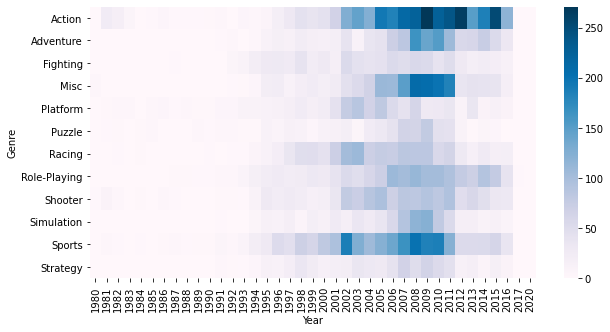

In [20]:
from scipy.stats import chi2_contingency

# 비디오게임이 흥행하던 98년~2013년도에 편향되어 있고, 그 중에서도 초중반까지 Sport Game이 자주 관측됬다면 중후반에는 Action이 더 자주 관측되는 패턴이 보인다. 
df[CAT_COL] = df[CAT_COL].astype('category') 
genre = df.groupby(['Genre','Year']).size().unstack(fill_value=0)
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(genre, cmap='PuBu');

# step : scipy를 이용해 chi2_contingency test
# H0 : 게임장르 빈도는 연도와 관련이 없다.
# H1 : 게임장르 빈도는 연도와 관련이 있다.
# 신뢰구간 : 95%

# pvalue가 0이라는 건, 0에 아주 가깝다는 뜻이다.
# 즉, 관련이 없다는 귀무가설이 맞을 확률이 0에 가깝다 ==> 관련이 있다
print('p_value :', chi2_contingency(genre, correction = False)[1])


p_value : 0.0


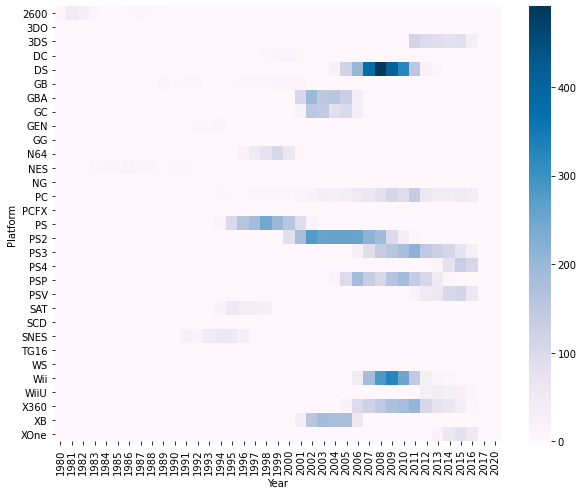

In [21]:
# 비디오게임이 흥행하던 98년~2013년도에 편향되어 있다.
# 이 시장은 플스, DS, Wii, Xbox의 패턴이 두드러지는데
# wii랑 Xbox, DS가 2000년대 초반에 자주 관측되는데에 비해 
# 플레이스테이션의 인기는 가정용(PSn시리즈) 에서 휴대용(PSV등)으로 변하면서 비교적 최근까지도 꾸준히 이어지고 있다고 보인다. 
platform = df.groupby(['Platform','Year']).size().unstack(fill_value=0)
fig,ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(platform, cmap='PuBu');

# H0 : 게임플랫폼 빈도는 연도와 관련이 없다.
# H1 : 게임플랫폼 빈도는 연도와 관련이 없다.
# 신뢰구간 : 95%

# pvalue가 0이라는 건, 0에 아주 가깝다는 뜻이다.
# 즉, 관련이 없다는 귀무가설이 맞을 확률이 0에 가깝다 ==> 관련이 있다
print('p_value :', chi2_contingency(platform, correction = False)[1])

##3. 지역에 따라서 선호하는 게임 장르가 다를까?.

이 데이터셋에서 특정 장르를 선호한다는 뜻은 특정 장르의 게임 출고량이 많다는 뜻이므로, 

장르별 출고량이 지역별로 차이가 있는지 확인해야 한다. 여기서는 장르별로 출고량의 평균을 내서, 지역별로 평균에 차이가 없는지 검정하겠음. 우리가 비교할 지역은 총 4개로, *ANOVA(Analysis of Variance)로 가설을 검정한다.

ANOVA (ANalysis Of VAriance; 분산 분석)은 여러 그룹간의 평균의 차이가 통계적으로 유의미 한지를 판단하기 위한 시험법



*   귀무가설 : 장르별 평균 출고량은 지역별로 차이가 없다.
*   대립가설 : 장르별 평균 출고량은 지역별로 차이가 있다.
*   신뢰구간 : 95%



In [22]:
# 게임 장르별 평균출고량을 지역별로 분류해둔 표. 이것만 보고 바로 안다면 당신은 천재! 
df_tidy.pivot_table(values='Sales', index='Genre', columns='Country', aggfunc='mean')

Country,EU_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,
Action,1.344541e+09,3.591637e+08,2.158029e+09,2.793691e+08
Adventure,1.102863e+08,4.728493e+07,2.126784e+08,6.300521e+07
Fighting,1.656852e+09,2.146448e+08,9.656979e+08,1.669083e+08
Misc,1.272417e+09,1.368038e+08,2.235667e+09,7.733206e+07
Platform,1.476201e+09,2.404237e+08,3.787691e+09,3.890738e+08
Puzzle,8.842830e+07,9.936396e+04,1.238896e+08,2.197880e+04
Racing,5.148981e+08,2.124641e+08,4.485581e+09,2.778401e+08
Role-Playing,2.058872e+07,2.612782e+09,8.255918e+08,4.979918e+08
Shooter,2.766363e+09,3.110967e+07,2.059498e+09,2.642596e+08


In [23]:
# 나라별 게임출고량에 장르별로 구분을 주었다. 이 그래프를 보고 해석이 다분할 수 있다.
# 일본이 RP를 좋아하는 것 같이 보이고, 전 지역 다 Action을 좋아하는 것 같긴한데,
# 그 외 지역에서 뚜렷하게 어떤 장르가 선호된다를 이 그래프로는 비교할 수 없다. 
import plotly.express as px

fig = px.bar(df_tidy, y="Sales", x="Country", color="Genre", barmode = 'stack')
fig.show()

In [24]:
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
%matplotlib inline

formula = 'Sales ~ C(Genre) + C(Country) + C(Genre):C(Country)'
lm = ols(formula, df_tidy).fit()
anova_lm(lm)

# PR(>F)를 pvalue로 해석하면 되는데, Country의 p-value < 0.05 로, country의 수준에 따라 평균출고량에 차이가 있다고 해석할 수 있지만 
# Genre의 수준에 따라 차이가 있다고 보기 어렵고, 장르와 지역간 상호작용 효과도 발견하지 못함.
# 따라서 지역에 따라 선호하는 장르가 다르다고 보기 어렵다.

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),11.0,1.175672e+22,1.068793e+21,0.876950,0.562446
C(Country),3.0,2.734065e+22,9.113550e+21,7.477714,0.000053
C(Genre):C(Country),33.0,2.994124e+22,9.073104e+20,0.744453,0.855042
Residual,65132.0,7.938038e+25,1.218762e+21,NaN,NaN


# Conclusion

지금껏 다음 분기에 어떤 게임을 제작해야 할까? 를 결정하기 위해,

카테고리(장르, 플랫폼, 제작사, 연도)별 출고량이 많은 항목이 무엇인지,

연도별 트렌드가 있었는지를 살펴봤다.


#"안전하게 간다면, Action 장르의 게임을 만든다. 콘솔을 하나만 고를 수 있다면 PS4, PS5같은 플스 가정용이 될 것."

비교적 플레이스테이션으로 할 수 있는 게임이 꾸준히 나오고 있고, Action게임은 특정 지역에 국한되지 않으면서 최근에 두루두루 잘 팔리는 게임이기 때문. 다만 Action은 출고량이 많은 만큼, 게임수도 많기 때문에 이미 레드오션일 가능성이 높다. 따라서 많은 작품 사이에서 묻히고 싶지 않다면, 게임 수가 비교적 적으면서, 상위랭킹의 출고량의 편차가 비교적 작은 시장을 탐색 해 보는 것도 하나의 전략이겠다. 

플스는 크게  가정용(PSn시리즈) 휴대용(PSVita, PSP 등)으로 나뉘는데, 최근 소니에서 구세대/휴대용 콘솔의 스토어를 폐지하면서 PS4, PS5 게임만 구매가 가능하다는 기사가 있어 참고했다.(https://www.thisisgame.com/webzine/news/nboard/263/?n=122065)(끝.)

